In [1]:
import re
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

In [2]:
def spaced_str(var):
  """Inserts spaces before capitalized letters.

  Args:
    word: The word to be modified.

  Returns:
    str: The string with spaces.
  """

  if isinstance(var, str):
    word = var
    idx_caps = [m.start() for m in re.finditer(r'[A-Z]', word)]

    # Inserts spaces before captalized letters except for the first one
    for i, idx in enumerate(idx_caps[1:]):
      word = word[:idx+i] + ' ' + word[idx+i:]

    return word
  return np.nan

def associated_workout(row, df_workout):
    """ For each register, finds correspondent exercise. """

    df_filter = df_workout[
        (df_workout['startDate'] <= row['startDate']) & 
        (df_workout['endDate'] >= row['startDate'])
    ]
    return df_filter['id'].iloc[0] if not df_filter.empty else None

In [3]:
df = pd.read_xml('./export/export_luiza/apple_health_export/export.xml')
df_bkp = df.copy()

In [4]:
df = df_bkp.copy()

In [5]:
df['duration'] = df['duration'].apply(lambda value: int(value) if pd.notna(value) else np.nan)
df['duration'] = df['duration'].astype('Int64')

In [6]:
df_metrics = df[df['startDate'].isna()].reset_index(drop=True)
df         = df[~df['startDate'].isna()].reset_index(drop=True)

In [7]:
today        = date.today()
this_month   = today.month
search_year  = today.year if this_month == 12 else today.year - 1
df_old_years = df[~df['startDate'].str.startswith(f"{search_year}")].reset_index(drop=True)
df           = df[df['startDate'].str.startswith(f"{search_year}")].reset_index(drop=True)

Getting birthday and gender data:

In [8]:
bday  = df_metrics.iloc[:, 1].dropna()
bday  = pd.to_datetime(bday.iloc[0])

age   = today.year - bday.year - ((today.month, today.day) < (bday.month, bday.day))

In [9]:
bio_sex = df_metrics.iloc[:, 2].dropna()
bio_sex = bio_sex.iloc[0].split('Sex')[1]

In [10]:
df_metrics = df_metrics.iloc[2:, :]

In [11]:
df_metrics_old_years = df_metrics[~df_metrics['dateComponents'].str.startswith(f"{search_year}")].reset_index(drop=True)
df_metrics           = df_metrics[df_metrics['dateComponents'].str.startswith(f"{search_year}")].reset_index(drop=True)

Dropping empty columns:

In [12]:
cols_to_drop = df.columns[df.isnull().all()]
df = df.drop(columns=cols_to_drop)

cols_to_drop = df_metrics.columns[df_metrics.isnull().all()]
df_metrics = df_metrics.drop(columns=cols_to_drop)

Dropping one-valued columns:

In [13]:
df_nan_1   = df.count()
idxs_nan_1 = df_nan_1[df_nan_1 == 1].index
cols_nan_1 = df_nan_1[idxs_nan_1].index.tolist()

df = df.drop(columns=cols_nan_1)

Analyzing and dropping unnecessary columns:

In [14]:
df = df.drop(columns=['sourceName', 'sourceVersion', 'device', 'WorkoutRoute'])

Removing the two first empty rows:

In [15]:
df = df.iloc[2:, :].reset_index(drop=True)

In [16]:
df['type'] = df['type'].str.split('Identifier').where(df['type'].notnull(), np.nan).str[1]
df['workoutActivityType'] = df['workoutActivityType'].str.split('ActivityType').where(df['workoutActivityType'].notnull(), np.nan).str[1]

In [17]:
df['workoutActivityType'] = df['workoutActivityType'].apply(spaced_str)

Separating Heart Rate data from Workout data:

In [18]:
df_heart_rate = df.loc[df['type'] == 'HeartRate'].reset_index(drop=True)
df_calories   = df.loc[df['type'] == 'ActiveEnergyBurned'].reset_index(drop=True)
df_workout    = df.loc[~df['workoutActivityType'].isna()].reset_index(drop=True)

In [19]:
cols_to_drop  = df_heart_rate.columns[df_heart_rate.isnull().all()]
df_heart_rate = df_heart_rate.drop(columns=cols_to_drop)
df_heart_rate = df_heart_rate.rename(columns={'value': 'heart_rate'})

cols_to_drop  = df_calories.columns[df_calories.isnull().all()]
df_calories = df_calories.drop(columns=cols_to_drop)
df_calories = df_calories.rename(columns={'value': 'calories'})

cols_to_drop = df_workout.columns[df_workout.isnull().all()]
df_workout  = df_workout.drop(columns=cols_to_drop)

In [20]:
df_heart_rate['heart_rate'] = df_heart_rate['heart_rate'].astype(float).astype(int)
df_calories['calories'] = df_calories['calories'].astype(float)

In [21]:
ids = pd.Series(range(1, len(df_workout) + 1))
df_workout = pd.concat([ids.rename('id'), df_workout], axis=1)

Associating each Heart Rate to an Exercise

In [22]:
# def associated_workout(row, df_workout):
#     # For each register, find correspondent exercise
#     df_filter = df_workout[
#         (df_workout['startDate'] <= row['startDate']) & 
#         (df_workout['endDate'] >= row['startDate'])
#     ]
#     return df_filter['id'].iloc[0] if not df_filter.empty else None

In [23]:
df_heart_rate['id'] = df_heart_rate.apply(lambda row: associated_workout(row, df_workout), axis=1)
df_calories['id']   = df_calories.apply(lambda row: associated_workout(row, df_workout), axis=1)

In [24]:
df_heart_rate = df_heart_rate[~df_heart_rate['id'].isna()].reset_index(drop=True)
df_calories   = df_calories[~df_calories['id'].isna()].reset_index(drop=True)

Creating important columns:

In [25]:
df_calories = df_calories.groupby(['id']).agg({'calories': 'sum'})

In [26]:
df_full = pd.merge(df_workout, df_heart_rate[['id', 'heart_rate']], on='id', how='left')
# df_full = pd.merge(df_full, df_calories, on='id', how='left')

Adding date columns:

In [27]:
months_dict = {1: 'JAN', 2: 'FEB', 3: 'MAR', 4: 'APR', 5: 'MAY', 6: 'JUN', 
            7: 'JUL', 8: 'AUG', 9: 'SEP', 10: 'OCT', 11: 'NOV', 12: 'DEC'}

df_full['date'] = df_full['startDate'].apply(lambda value: value[:10])
df_full['month'] = df_full['date'].apply(lambda value: int(value[5:7]))
df_full['month_name'] = df_full['month'].map(months_dict)
df_full['year']  = df_full['creationDate'].apply(lambda value: value[:4])

df_metrics['month'] = df_metrics['dateComponents'].apply(lambda value: int(value[:7][-2:]))
df_metrics['month_name'] = df_metrics['month'].map(months_dict)

Defining Heart Rate info necessary:

In [28]:
col_names_hr = ['id', 'workoutActivityType', 'duration', 'date','month', 'month_name' ]

In [41]:
df_hr_mean = df_full.groupby(col_names_hr).agg({'heart_rate': 'mean'})
df_hr_mean = df_hr_mean.reset_index()
df_hr_mean = df_hr_mean.rename(columns={'heart_rate': 'heart_rate_mean'})

# df_hr_mean_min = df_hr_mean['heart_rate_mean'].min()
# df_hr_mean = df_hr_mean.fillna(df_hr_mean_min)

df_hr_mean['heart_rate_mean'] = df_hr_mean['heart_rate_mean'].apply(lambda value: int(value) if not pd.isna(value) else value)

In [43]:
serie_hr_max = df_full.groupby(col_names_hr).agg({'heart_rate': 'max'}).reset_index(drop=True)
serie_hr_max.columns = ['heart_rate_max']

df_v1 = pd.concat([df_hr_mean, serie_hr_max], axis=1)

In [44]:
df_v2 = pd.merge(df_v1, df_calories, on='id', how='left')
df_v2['calories'] = df_v2['calories'].fillna(0)
df_v2['calories'] = df_v2['calories'].astype(int)

Results:

Top sports:

In [45]:
sports_by_count    = df_v2['workoutActivityType'].value_counts()
total_sports       = len(sports_by_count)
top_sport_by_count = sports_by_count.idxmax()
count_top_sport    = sports_by_count.max()

top_sports_by_time = df_v2.groupby(by=['workoutActivityType']).agg({'duration': 'sum', 'calories': 'sum'}).sort_values(by='duration', ascending=False)

top_sport_by_time       = top_sports_by_time.idxmax().iloc[0]
time_top_sport          = top_sports_by_time.max().iloc[0]
count_top_sport_by_time = sports_by_count[top_sport_by_time]

top_5_sports_by_time    = top_sports_by_time.iloc[:5, :].reset_index()
top_5_sports_by_time.columns = ['Sport', 'Total Minutes', 'Total Calories']

Heart Rate:

In [46]:
highest_heart_rate = df_v2.loc[df_v2['heart_rate_max'].idxmax(), :]
heart_rate_per_sport = df_v2.groupby(['workoutActivityType']).agg({'heart_rate_mean': 'mean'})
sport_highest_avg_heart_rate = heart_rate_per_sport.idxmax().iloc[0]
highest_avg_heart_rate = int(heart_rate_per_sport.max().iloc[0])

Calories:

In [47]:
calories_per_sport = df_v2.groupby(['workoutActivityType']).agg({'calories': 'mean'})
sport_highest_avg_calories = calories_per_sport.idxmax().iloc[0]
highest_avg_calories = int(calories_per_sport.max().iloc[0])

Total time exercising and goals:

In [48]:
exercise_total_time = top_sports_by_time['duration'].sum()
exercise_total_days = len(df_v2['date'].drop_duplicates())

In [49]:
energy_goal_check = df_metrics[(df_metrics['activeEnergyBurned'] >= df_metrics['activeEnergyBurnedGoal']) & (df_metrics['activeEnergyBurnedGoal'] > 0)].reset_index(drop=True)
days_energy_goal_check = energy_goal_check.shape[0]

start_date = date(date.today().year, 1, 1)
days_since_start_of_year = (today - start_date).days
percent_goal_check_so_far = round(days_energy_goal_check/days_since_start_of_year*100, 2)

Top day of exercises:

In [ ]:
top_exercise_day_data = df_v2.groupby(['date']).agg({'duration': 'sum', 'calories': 'sum'})
top_exercise_day = top_exercise_day_data.idxmax()['duration']
top_exercise_day_calories = top_exercise_day_data.loc[top_exercise_day, 'calories']
top_exercise_day_time = top_exercise_day_data.loc[top_exercise_day, 'duration']

top_exercise_day_training = df_v2.loc[df_v2['date'].str.startswith(top_exercise_day)]
top_exercise_day_training = top_exercise_day_training.rename(
    columns={
        'workoutActivityType': 'Sport',
        'duration': 'Total Minutes',
        'calories': 'Total Calories'
    }
)

Most active day:

In [61]:
top_active_day_data = df_metrics.loc[df_metrics['activeEnergyBurned'].idxmax(), ['dateComponents', 'activeEnergyBurned', 'appleExerciseTime']]
top_active_day = top_active_day_data['dateComponents']
top_active_day_calories = top_active_day_data['activeEnergyBurned']
top_active_day_time = top_active_day_data['appleExerciseTime']

top_active_day_training = df_v2.loc[df_v2['date'].str.startswith(top_active_day)]
top_active_day_training = top_active_day_training.rename(
    columns={
        'workoutActivityType': 'Sport',
        'duration': 'Total Minutes',
        'calories': 'Total Calories'
    }
)

top_active_day_training_none = None

Showing all of the results:

In [52]:
if top_sport_by_count != top_sport_by_time:
    print(f'Your top sport by number of registers is: {top_sport_by_count} and you practiced it {count_top_sport} times this year.')
    print(f'But your top sport by time is: {top_sport_by_time} and you practiced it {count_top_sport_by_time} times this year for {(time_top_sport)} minutes.')
else:
    print(f'Your top sport is: {top_sport_by_time} and you practiced it {count_top_sport_by_time} times this year for {(time_top_sport)} minutes.')

print(f' ')
print(f'Your top 5 sports are:')
print(f'{top_5_sports_by_time}')

Your top sport by number of registers is: Flexibility and you practiced it 143 times this year.
But your top sport by time is: Pilates and you practiced it 72 times this year for 4128 minutes.
 
Your top 5 sports are:
                           Sport  Total Minutes  Total Calories
0                        Pilates           4128           14014
1  Traditional Strength Training           2308            9673
2                    Flexibility           1070            3921
3                        Walking            795            3724
4                        Running            759            5313


In [ ]:
print(f'You exercised for {exercise_total_time} minutes this year in {exercise_total_days} different days.')
print(f'And you tried out {total_sports} different sports!')
print(f' ')
print(f'The day you exercised the most was {top_exercise_day}: {top_exercise_day_time} minutes! You burned {int(top_exercise_day_calories)} calories!')

top_exercise_day_training = top_exercise_day_training.reset_index(drop=True)
print(f"Exercises: ")
print(f"{top_exercise_day_training[['Sport', 'Total Minutes', 'Total Calories']]}")

You exercised for 9978 minutes this year in 190 different days.
And you tried out 10 different sports!
 
The day you exercised the most was 2024-08-21: 262 minutes! You burned 0 calories!
Exercises: 
    Sport  Total Minutes  Total Calories
0  Hiking            262               0


In [66]:
print(f'Now, your most active day was... {top_active_day}! ')
print(f'Your movement ring reached {int(top_active_day_calories)} calories and your exercise ring registered {top_active_day_time} minutes!')

if top_active_day_training.empty:
    top_active_day_training_none = 'However, there are no exercises registered for this day...'
    print(top_active_day_training_none)
else:
    top_active_day_training = top_active_day_training.reset_index(drop=True)
    print(f"Exercises: ")
    print(f"{top_active_day_training[['Sport', 'Total Minutes', 'Total Calories']]}")

Now, your most active day was... 2024-03-10! 
Your movement ring reached 856 calories and your exercise ring registered 132.0 minutes!
However, there are no exercises registered for this day...


In [54]:
print(f'You reached your movement goal on {days_energy_goal_check} days this year!')
print(f'That represents {percent_goal_check_so_far}% of the year so far!')

You reached your movement goal on 14 days this year!
That represents 4.06% of the year so far!


In [55]:
print(f'The sport that makes your heart race is: {sport_highest_avg_heart_rate}!')
print(f'The average heart rate you get when practicing it is {highest_avg_heart_rate} bpm.')

The sport that makes your heart race is: Elliptical!
The average heart rate you get when practicing it is 164 bpm.


In [56]:
print(f'But the sport that really makes you burn is {sport_highest_avg_calories} with an average of {highest_avg_calories} calories per session!')

But the sport that really makes you burn is Running with an average of 231 calories per session!


In [57]:
df_metrics_per_month = df_metrics.groupby(['month', 'month_name']).agg({'appleExerciseTime': 'sum'}).reset_index()
df_metrics_per_month['hours'] = df_metrics_per_month['appleExerciseTime'].apply(lambda value: round(value/60, 1))

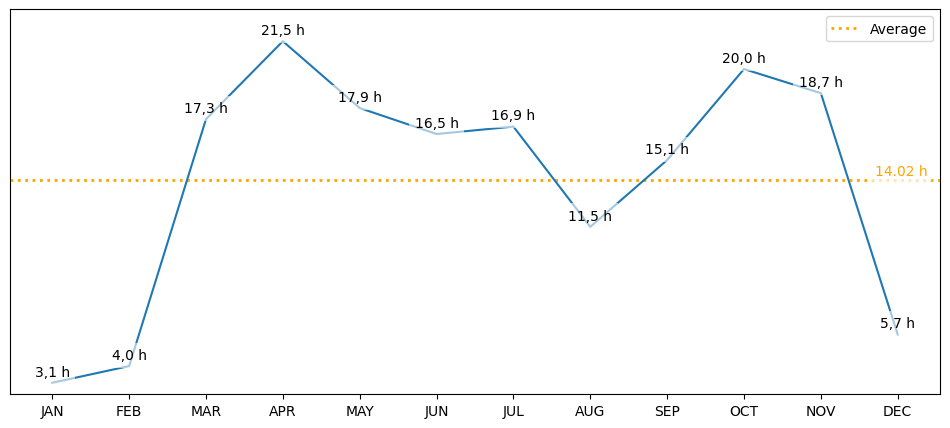

In [58]:
fig, ax1 = plt.subplots(figsize=(12, 5))

mean_value = df_metrics_per_month['hours'].mean()
ax1.axhline(mean_value, color='orange', linestyle=':', linewidth=2, label='Average')
ax1.annotate(
    f'{mean_value:.2f} h',  # Texto a ser exibido, ajustado para duas casas decimais
    xy=(0.93, mean_value*1.02),  # Coordenadas (x, y) para posicionar a anotação
    xycoords=('axes fraction', 'data'),  # Define que x usa fração dos eixos e y os dados
    fontsize=10,  # Tamanho da fonte
    color='orange',  # Cor do texto
    bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.7)  # Fundo branco com leve transparência
)

lp_time_per_month = sns.lineplot(data=df_metrics_per_month, x='month_name', y='hours')
ax1.set_xlabel('');
ax1.yaxis.set_visible(False)

y_min = df_metrics_per_month['hours'].min()
y_max = df_metrics_per_month['hours'].max()
ax1.set_ylim(y_min * 0.8, y_max * 1.08)

for i, row in df_metrics_per_month.iterrows():
    ax1.annotate(
        text=f"{str(row['hours']).replace('.', ',')} h",  # Texto da anotação
        xy=(row['month_name'], row['hours']),  # Coordenadas do ponto
        xytext=(0, 5),  # Deslocamento em relação ao ponto (x, y)
        textcoords='offset points',  # Usa o deslocamento definido acima
        ha='center', fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

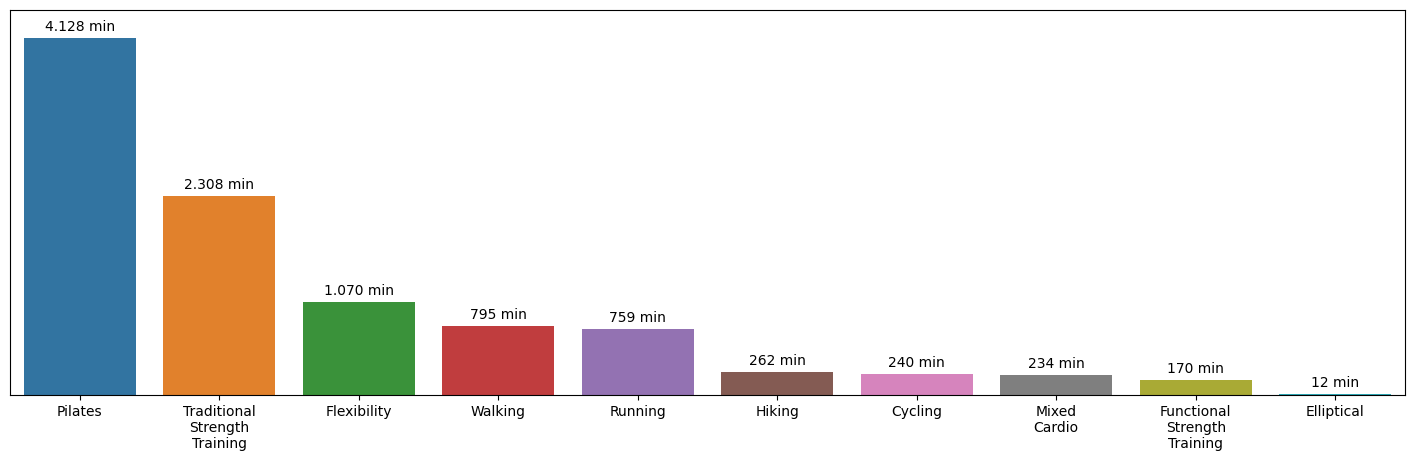

In [59]:
df_v2_gb = df_v2.groupby(['month', 'month_name', 'workoutActivityType']).agg({'duration': 'sum'}).reset_index()
df_v2_sport_time = df_v2.groupby(['workoutActivityType']).agg({'duration': 'sum'}).reset_index()
df_v2_sport_time = df_v2_sport_time.sort_values(by='duration', ascending=False)

fig, ax1 = plt.subplots(figsize=(18, 5))
lp_time_per_sport = sns.barplot(data=df_v2_sport_time, x='workoutActivityType', y='duration', hue='workoutActivityType');
ax1.yaxis.set_visible(False)
ax1.set_ylim()

labels = [textwrap.fill(label, width=11) for label in df_v2_sport_time['workoutActivityType']]  # Limitando a 14 caracteres e quebrando a linha
ax1.set_xticks(range(len(labels)))  # Definindo o número de ticks com base no número de rótulos
ax1.set_xticklabels(labels, rotation=0, fontdict={'fontsize': 10});  
ax1.set_xlabel('');

y_max = df_v2_sport_time['duration'].max()
ax1.set_ylim(0, y_max * 1.08)

for container in lp_time_per_sport.containers:
    labels = [f'{v.get_height():,.0f} min'.replace(',', '.') if v.get_height() != 0 else '' for v in container]
    lp_time_per_sport.bar_label(container, labels=labels, padding=3, fontsize=10, bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0, edgecolor='none'))